Work with pairwise sequence distances:
- remove samples that dramatically increase within-species distances (potential mis-identification)
- maximum within-species thresholds (95% assuming normal distribution)
- effect of gaps on increased thresholds compared to Ag1000g data

Manual steps: choice of species to inspect, removal of bad samples

In [1]:
%run common.ipynb

In [2]:
# read mosquito sequencing data
seq = pd.read_csv(COMB_SEQ, dtype=str)
display(seq.shape)
seq.head(1)

(10057, 6)

,s_Sample,target,consensus,reads,species,combUID
0,Abro-21,13,TCTCCATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATG...,23,Anopheles_brohieri,13-0


## Estimate pairwise distances

In [3]:
dm_data = []
for ampl in AMPLS:
    # read alignment
    aln = AlignIO.read(open(ALN_ALL.format(ampl)), 'fasta')
    # calculate identity distance matrix
    dm = DistanceCalculator('identity').get_distance(aln)
    dm = pd.DataFrame(dm.matrix, index=dm.names, columns=dm.names)
    # re-format to pairwise distances, clean-up
    pdist = dm.unstack() \
              .dropna() \
              .reset_index()
    pdist.columns = ['seq1','seq2','dist']
    pdist = pdist[pdist.seq1 != pdist.seq2]
    pdist['target'] = ampl
    dm_data.append(pdist)
dm_data = pd.concat(dm_data)
dm_data.sample(3)

,seq1,seq2,dist,target
1266,46-12,46-24,0.131868,46
1424,18-11,18-38,0.329317,18
4570,16-35,16-125,0.286119,16


## Mark within-species distances

In [4]:
# species per sequence
spp_per_seq = seq.groupby('combUID')['species'].unique()
spp_per_seq = spp_per_seq.apply(lambda x: set(x))

In [5]:
def common_species(x):
        try:
            return ';'.join((spp_per_seq[x.seq1] & spp_per_seq[x.seq2]))
        except:
            raise ValueError(x)

dm_data['spp_intersect'] = dm_data.apply(lambda x: common_species(x),
                                         axis=1)

## Explore within-species distances

In [6]:
# species with multiple samples passing few amplicons filter
samples_per_sp = seq.groupby('species')['s_Sample'].nunique()
multisample_species = samples_per_sp[samples_per_sp > 1].index
display(multisample_species.shape)
multisample_species

(35,)

Index(['Anopheles_aconitus', 'Anopheles_annularis', 'Anopheles_arabiensis',
       'Anopheles_barbirostris', 'Anopheles_brohieri', 'Anopheles_carnevalei',
       'Anopheles_coluzzii', 'Anopheles_coustani', 'Anopheles_demeilloni',
       'Anopheles_dirus_A', 'Anopheles_dureni', 'Anopheles_funestus',
       'Anopheles_gambiae', 'Anopheles_hancocki', 'Anopheles_hyrcanus',
       'Anopheles_implexus', 'Anopheles_jamesii', 'Anopheles_maculatus_A',
       'Anopheles_maculipalpis', 'Anopheles_marshallii', 'Anopheles_minimus_A',
       'Anopheles_moucheti', 'Anopheles_nili', 'Anopheles_paludis',
       'Anopheles_rampae', 'Anopheles_rhodesiensis', 'Anopheles_sinensis',
       'Anopheles_stephensi', 'Anopheles_sundaicus', 'Anopheles_tenebrosus',
       'Anopheles_tessellatus', 'Anopheles_theileri', 'Anopheles_vagus',
       'Anopheles_vinckei', 'Anopheles_ziemanni'],
      dtype='object', name='species')

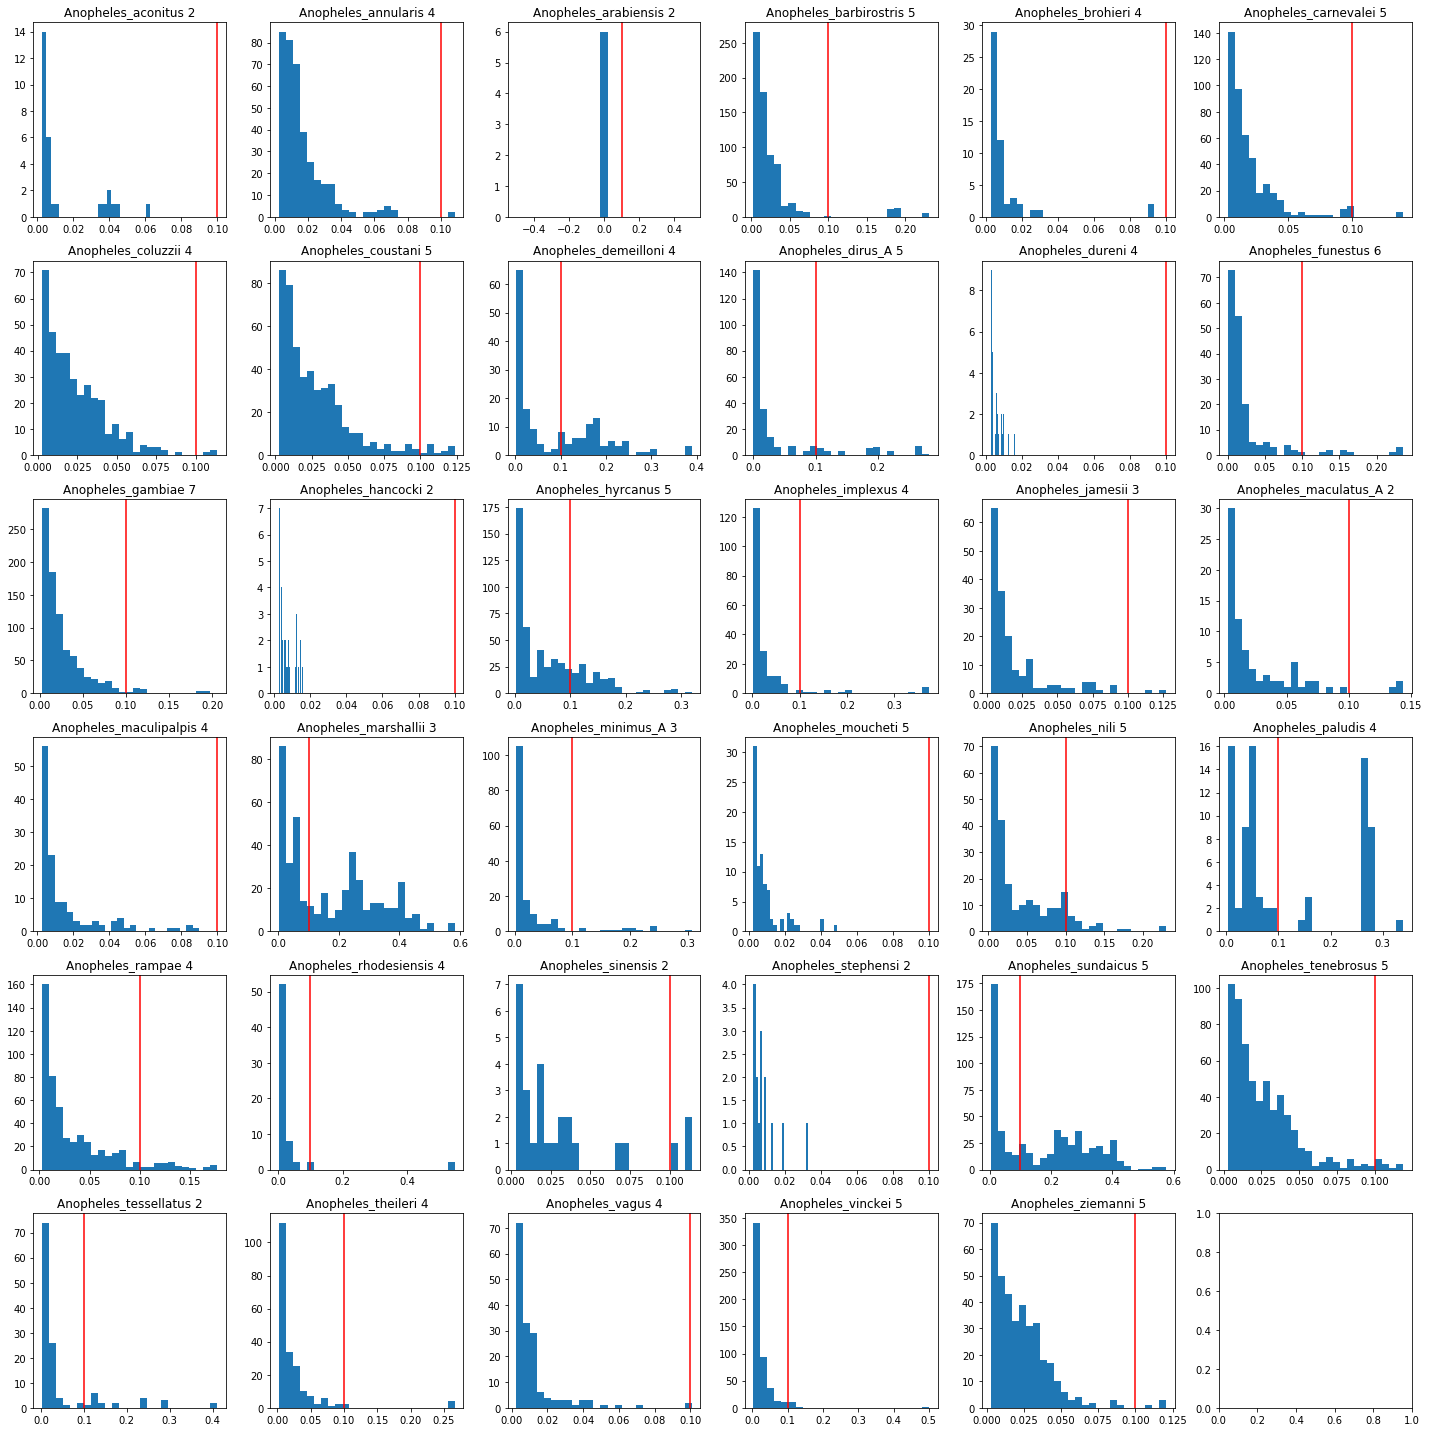

In [7]:
# Most species have less than 10% within-species divergence averaged across all amplicons. 
# However, in some species there is a substantial number of distances that are higher than that. 
fig, axs = plt.subplots(6,6, figsize=(20,20))
for ax, sp in zip(axs.flatten(), multisample_species):
    ax.axvline(0.1, c='r')
    ax.hist(dm_data.loc[dm_data.spp_intersect.str.contains(sp),
                        'dist'], bins=25)
    ax.set_title('{} {}'.format(sp, samples_per_sp[sp]))
fig.tight_layout();

## Remove samples to decrease average within-species distance


If some samples were incorrectly identified, removal of those will result in dramatic reduction of average within-species distances for the remaining samples. If removing samples does not help, we consider entire species as bad. Here, we only check species with significant number of distances higher than 0.1. Small number of high distances are more likely to occur only in a few amplicons, so we will address these cases later.

In [8]:
def sample_dists(species, excluded_samples=[]):
    '''
    Distance distribution statistics within given species 
    relative to a single sample at once.
    
    A set of samples can be removed from consideration prior 
    to the analysis.
    '''
    # subset samples
    species_samples = seq[seq['species'] == species] \
                               ['s_Sample'].unique().tolist()
    for sample in excluded_samples:
        try:
            species_samples.remove(sample)
        except:
            pass
    # excluded seqs
    excluded_seqs = seq[seq.s_Sample.isin(excluded_samples)] \
                               ['combUID'].unique().tolist()
    # subset distances data to species
    species_dists = dm_data[dm_data.spp_intersect.str.contains(species)]
    # remove distances to sequences of excluded samples
    species_dists = species_dists[~species_dists.seq1.isin(excluded_seqs) &
                                  ~species_dists.seq2.isin(excluded_seqs)]
    sample_dists = dict()
    for sample in species_samples:
        sample_seqs = seq[seq.s_Sample == sample] \
                               ['combUID'].unique().tolist()
        sample_dists[sample] = species_dists.loc[species_dists.seq1.isin(sample_seqs) |
                                                 species_dists.seq2.isin(sample_seqs),
                                                 'dist'].describe()
    return pd.DataFrame(sample_dists).T.sort_values('mean', ascending=False)

In [9]:
# in dem, one sample stands out
sample_dists('Anopheles_demeilloni')

,count,mean,std,min,25%,50%,75%,max
Adem-15,117.0,0.121497,0.092212,0.002710,0.032680,0.130312,0.174545,0.388679
Adem-34,122.0,0.081776,0.092066,0.002681,0.007619,0.033918,0.159864,0.388679
Adem-32,62.0,0.081055,0.099130,0.002915,0.006626,0.018335,0.165019,0.388679
Adem-19,89.0,0.075736,0.092592,0.002681,0.006944,0.020725,0.136729,0.388679


In [10]:
# removal of a single sample dramatically reduces distances - other subspecies/species
bad_samples = ['Adem-15']
sample_dists('Anopheles_demeilloni', bad_samples)

,count,mean,std,min,25%,50%,75%,max
Adem-34,46.0,0.008863,0.010012,0.002681,0.004128,0.006716,0.008701,0.068681
Adem-19,38.0,0.008138,0.005133,0.002681,0.004267,0.006716,0.008643,0.022831
Adem-32,26.0,0.006689,0.003423,0.002915,0.004128,0.006009,0.008007,0.018265


In [11]:
# single sample with very low seqeunce recall stands out
sample_dists('Anopheles_hyrcanus', bad_samples)

,count,mean,std,min,25%,50%,75%,max
VBS00084,21.0,0.115841,0.073323,0.006944,0.021680,0.151762,0.176152,0.186992
VBS00082,290.0,0.067484,0.065876,0.002611,0.011976,0.048780,0.110215,0.319392
VBS00083,298.0,0.065811,0.061452,0.002611,0.012404,0.048780,0.100392,0.319392
VBS00085,271.0,0.065789,0.062124,0.002660,0.012579,0.050938,0.099150,0.292096
VBS00086,239.0,0.061644,0.059189,0.002660,0.012183,0.042373,0.097734,0.288973


In [12]:
# removal of a single sample dramatically reduces distances
bad_samples.append('VBS00084')
sample_dists('Anopheles_hyrcanus', bad_samples)

,count,mean,std,min,25%,50%,75%,max
VBS00082,282.0,0.067512,0.065886,0.002611,0.011740,0.049547,0.110076,0.319392
VBS00083,288.0,0.065193,0.061087,0.002611,0.012346,0.048780,0.096774,0.319392
VBS00085,265.0,0.064453,0.060957,0.002660,0.012579,0.050532,0.096774,0.292096
VBS00086,234.0,0.060619,0.058185,0.002660,0.012140,0.042373,0.096317,0.288973


In [13]:
# there is no single sample removal of which would dramatically reduce the distances
sample_dists('Anopheles_marshallii', bad_samples)

,count,mean,std,min,25%,50%,75%,max
Amar-5,260.0,0.227367,0.150177,0.002681,0.062714,0.248272,0.345367,0.582222
Amar-3-1,241.0,0.171919,0.139462,0.002611,0.051282,0.150000,0.253264,0.582222
Amar-42,265.0,0.169674,0.140084,0.002611,0.044586,0.148352,0.267327,0.577778


In [14]:
# remove all samples
bad_samples.extend(['Amar-5','Amar-3-1','Amar-42'])

In [15]:
# in nili, distances are over-dispersed
sample_dists('Anopheles_nili', bad_samples)

,count,mean,std,min,25%,50%,75%,max
Anil-239,136.0,0.052352,0.047252,0.002681,0.012346,0.039688,0.088183,0.230241
Anil-237,114.0,0.048943,0.047320,0.002681,0.011577,0.032410,0.083874,0.230241
Anil-233,136.0,0.043322,0.045054,0.002747,0.011151,0.022310,0.070755,0.226804
Anil-236,145.0,0.042427,0.042011,0.002747,0.010989,0.022642,0.064426,0.230241
Anil-238,138.0,0.041397,0.042006,0.002747,0.010811,0.019875,0.064426,0.226804


In [16]:
# here, two samples are spurious
sample_dists('Anopheles_paludis', bad_samples)

,count,mean,std,min,25%,50%,75%,max
Apal-10,42.0,0.175881,0.114503,0.002710,0.052168,0.269648,0.271003,0.276423
Apal-4,2.0,0.172422,0.235166,0.006135,0.089279,0.172422,0.255566,0.338710
Apal-81,61.0,0.107966,0.107322,0.002710,0.035230,0.052209,0.271003,0.338710
Apal-257,32.0,0.097947,0.091197,0.006135,0.037940,0.054201,0.150362,0.271003


In [17]:
# the remaining two are closely related
bad_samples.extend(['Apal-10','Apal-4'])
sample_dists('Anopheles_paludis', bad_samples)

,count,mean,std,min,25%,50%,75%,max
Apal-257,20.0,0.064915,0.041755,0.016949,0.03794,0.05185,0.071701,0.157258
Apal-81,34.0,0.045113,0.040953,0.002710,0.01154,0.04065,0.053703,0.157258


In [18]:
# samples are close, some dispersion exists
sample_dists('Anopheles_rampae', bad_samples)

,count,mean,std,min,25%,50%,75%,max
VBS00112,287.0,0.032691,0.036608,0.002611,0.006312,0.016129,0.047575,0.177419
VBS00115,281.0,0.030838,0.037182,0.002611,0.006173,0.013699,0.038627,0.174731
VBS00114,298.0,0.030012,0.035230,0.002611,0.006173,0.015077,0.041353,0.177419
VBS00113,269.0,0.028758,0.032385,0.002611,0.006173,0.014663,0.041353,0.172043


In [19]:
# one sample stands out
sample_dists('Anopheles_sundaicus', bad_samples)

,count,mean,std,min,25%,50%,75%,max
VBS00145,419.0,0.215353,0.135393,0.002611,0.095502,0.230189,0.316884,0.574344
VBS00144,221.0,0.165115,0.157794,0.002611,0.007833,0.110266,0.297059,0.574344
VBS00146,265.0,0.161817,0.153690,0.002611,0.008333,0.096220,0.300000,0.574344
VBS00148,272.0,0.154130,0.153205,0.002611,0.008333,0.091718,0.288952,0.574344
VBS00147,242.0,0.146546,0.146782,0.002611,0.007969,0.091531,0.273932,0.574344


In [20]:
# remaining samples are very close
bad_samples.append('VBS00145')
sample_dists('Anopheles_sundaicus', bad_samples)

,count,mean,std,min,25%,50%,75%,max
VBS00146,94.0,0.010750,0.017292,0.002611,0.003774,0.006350,0.008744,0.093484
VBS00148,103.0,0.009576,0.013201,0.002611,0.004032,0.007326,0.009788,0.093484
VBS00147,89.0,0.009166,0.012738,0.002611,0.004016,0.006024,0.008333,0.087819
VBS00144,75.0,0.008290,0.011907,0.002611,0.003663,0.005222,0.007885,0.090652


## Finalise list of bad samples with known problematic species

In [21]:
# from preliminary species tree analysis we saw
# that An. rhodesiensis position is compromised
# and it belongs to different series
# we will remove all of the samples of this species

# update - not removing as similar series swap occured for An. jebudensis
# bad_samples.extend(['Arho-7-1','Arho-7-2','Arho-7-3','Arho-7-4'])


In [22]:
bad_samples

['Adem-15',
 'VBS00084',
 'Amar-5',
 'Amar-3-1',
 'Amar-42',
 'Apal-10',
 'Apal-4',
 'VBS00145']

In [23]:
# write bad samples
with open(BAD_SAMPLES, 'w') as o:
    # header
    o.write('s_Sample\n')
    # samples
    for sample in bad_samples:
        o.write(sample + '\n')
        

## Remove bad samples from within-species distances

In [24]:
# replace bad sample's species with empty string
seq.loc[seq.s_Sample.isin(bad_samples),'species'] = ''

In [25]:
def rm_empty(x):
    x = set(x)
    x.discard('')
    return x
# species per sequence with bad samples removed
spp_per_seq = seq.groupby('combUID')['species'].unique()
spp_per_seq = spp_per_seq.apply(rm_empty)
spp_per_seq['0-11']

set()

In [26]:
# mark within-species distances species, hq - bad samples removed
dm_data['spp_intersect_hq'] = dm_data.apply(lambda x: common_species(x),
                                            axis=1)

dm_data.head(1)

,seq1,seq2,dist,target,spp_intersect,spp_intersect_hq
1,0-0,0-1,0.472103,0,,


## Within-species variant thresholds

Variant counts are not affected by gaps introduced in the alignment, unlike normalised distances.

In [27]:
t_data = pd.read_csv(GC_THRESHOLDS, dtype={'Primary_ID':str})
t_data = t_data.rename(columns={'Primary_ID':'target',
                                'max_withinspecies_var':'var_ag1k',
                                'max_withinspecies_dist':'dist_ag1k'})
t_data.head(1)

,target,start_insert,end_insert,len_insert,var_ag1k,dist_ag1k
0,0,10356439,10356587,149,5.0,0.033557


In [28]:
# read alignment lengths
aln_len = dict()
for ampl in AMPLS:
    aln = AlignIO.read(open(ALN_ALL.format(ampl)), 'fasta')
    aln_len[ampl] = aln.get_alignment_length()
aln_len['56']

152

In [29]:
# alignment lengths to dm
dm_data['aln_len'] = dm_data.target.replace(aln_len)
# variants
dm_data['var'] = (dm_data['dist'] * dm_data['aln_len'] + 0.01).astype(int)
dm_data.head(1)

,seq1,seq2,dist,target,spp_intersect,spp_intersect_hq,aln_len,var
1,0-0,0-1,0.472103,0,,,233,110


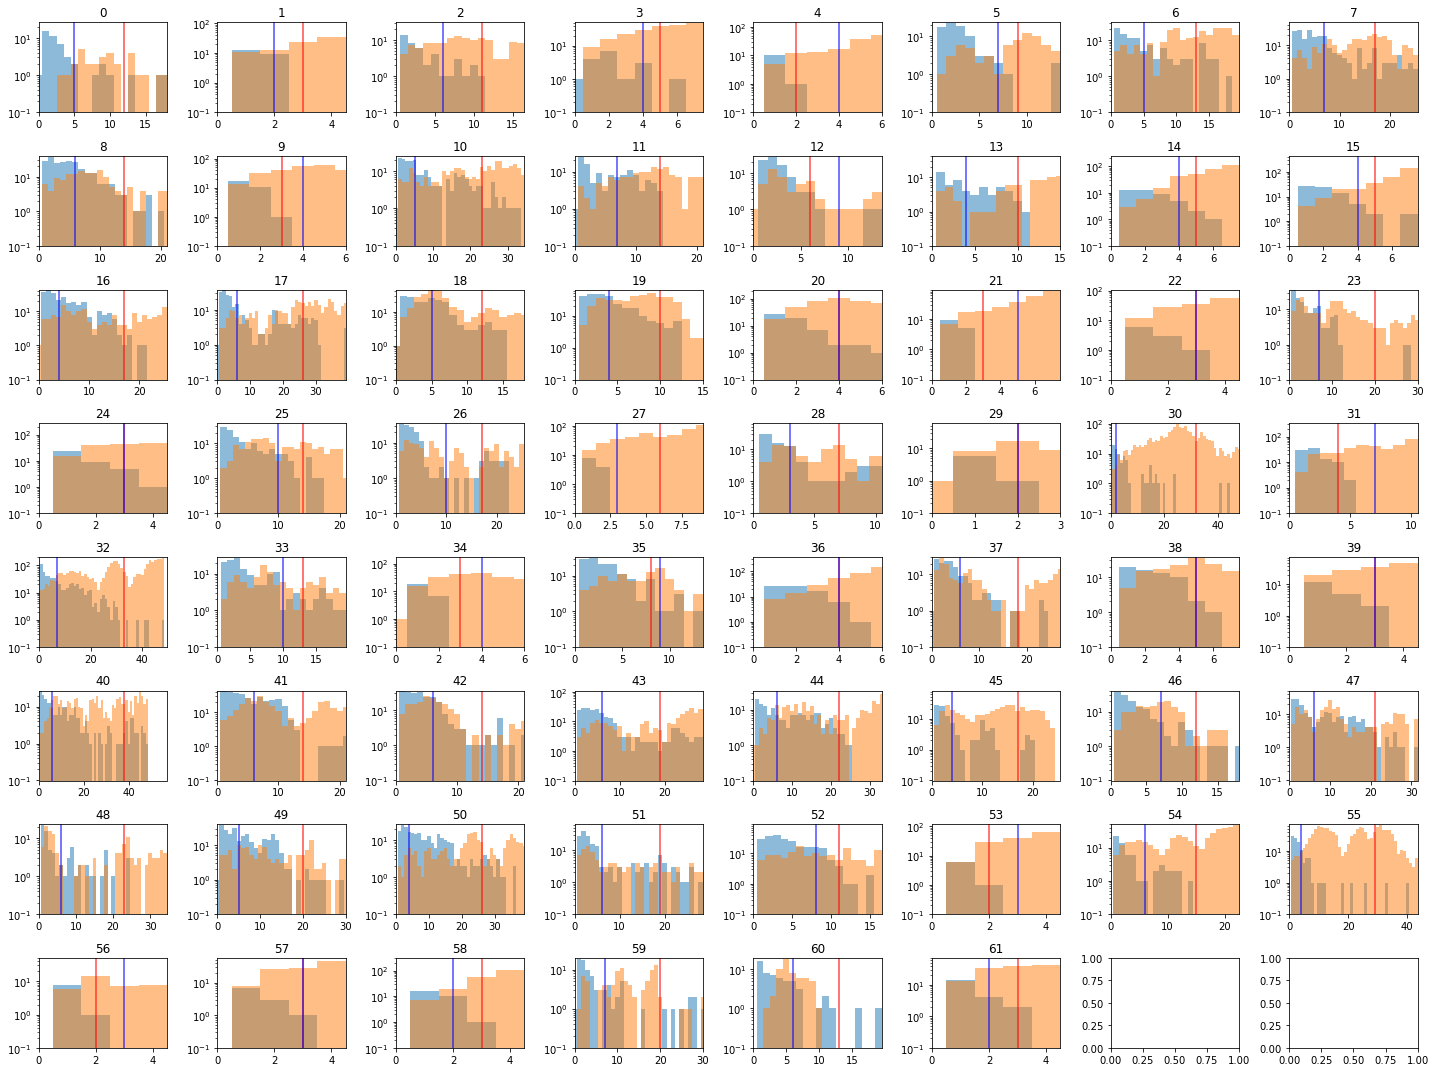

In [30]:
multisp_t = dict()

max_dist = 50

fig,axs = plt.subplots(8,8, figsize=(20,15))
bins = np.arange(0, float(max_dist)) - 0.5
kde_bins = np.linspace(0, max_dist, 500)
for i, ampl in enumerate(AMPLS):
    
    # set axis
    ax = axs.flatten()[i]
    
    # get max ag1k within-species distance
    gct = t_data.loc[t_data.target == ampl, 'var_ag1k'].iloc[0]
    
    # subset distances to amplicon
    ampl_data = dm_data[dm_data.target == ampl]
    # within-species histogram
    wspv = ampl_data.loc[ampl_data['spp_intersect_hq'] != '', 'var']
    # between-species histogram
    bspv = ampl_data.loc[ampl_data['spp_intersect_hq'] == '', 'var']
    # estimate threshold
    # remove top 5% within-species distances - hopefully rid of outliers
    v = wspv.sort_values()[:int(0.95 * wspv.shape[0])]
    # make symmetrical
    v = pd.concat([v,-v])
    # take double standard deviation (95% interval) and round to nvsr
    t = round(v.std() * 2)
    multisp_t[ampl] = t
    
    # plot data
    ax.hist(wspv, bins=bins, alpha=0.5)
    ax.hist(bspv, bins=bins, alpha=0.5)
    ax.axvline(t, c='r', alpha=0.7)
    ax.axvline(gct, c='b', alpha=0.7)
    # plotting settings
    ax.set_xlim(0, max(gct, t) * 1.5)
    ax.set_ylim(0.1)
    ax.set_yscale('log')
    ax.set_title(ampl)
fig.tight_layout()

Key observation - gambiae-based thresholds are often lower than multi-species-based thresholds. In some cases this happens because of erroneous inclusion of high-distance outliers (e.g., `0`). In other cases this is more systematic - `8`,`13` etc. Mixed cases exist. 

Let's correlate difference between ag1k and multispecies thresholds with number of gaps in alignment

## Mean number of gaps in alignment

In [31]:
ngaps = dict()
for ampl in AMPLS:
    aln = AlignIO.read(open(ALN_ALL.format(ampl)), 'fasta')
    gaps = [str(s.seq).count('-') for s in aln]
    ngaps[ampl] = np.mean(gaps)
ngaps['0']

95.27536231884058

## Correlate gaps with difference in thresholds

In [32]:
# add alignment length
t_data['aln_len'] = t_data.target.replace(aln_len)
# add ngaps
t_data['ngaps_mean'] = t_data.target.replace(ngaps)
# add minimum multispecies threshoulds
t_data['var_multisp'] = t_data.target.replace(multisp_t)
# add difference between multispecies and ag1k thresholds
t_data['delta_t'] = t_data.var_multisp - t_data.var_ag1k
t_data.head(1)

,target,start_insert,end_insert,len_insert,var_ag1k,dist_ag1k,aln_len,ngaps_mean,var_multisp,delta_t
0,0,10356439,10356587,149,5.0,0.033557,233,95.275362,12.0,7.0


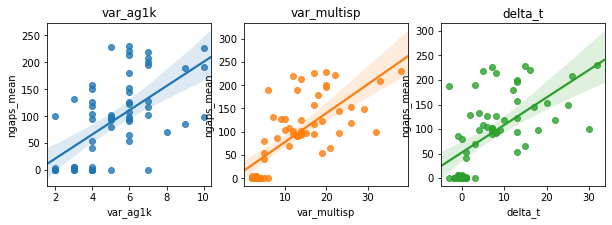

In [33]:
# correlate?
fig, axs = plt.subplots(1,3, figsize=(10,3))
for i, t in enumerate(['var_ag1k','var_multisp','delta_t']):
    sns.regplot(x=t, y='ngaps_mean', data=t_data, ax=axs[i])
    axs[i].set_title(t);

Correlation with number of gaps exists for all types of thresholds, and difference between threshold types is also affected.

Thus, higher thresholds for gapped alignments are appropriate.  

## Write threshold data to file

In [34]:
t_data.to_csv(COMB_THRESHOLDS, index=False)